In [27]:
%%time
import sys
import os

# sys.path.append('/eos/home-i03/b/bewing/.local/lib/python3.9/site-packages')

import pickle
import json
import uuid
import hls4ml
from hls4ml.model.graph import ModelGraph
from hls4ml.model.layers import GRU, LSTM, SeparableConv1D, SeparableConv2D
import profiling
from profiling import *
__tf_profiling_enabled__ = True
__torch_profiling_enabled__ = True

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import mplhep as hep
mpl.rcParams.update({'font.size': 20})

import tensorflow as tf
# print(tf.__version__)
# # print(tf.__file__)

from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam, Nadam
from tensorflow.keras.layers import BatchNormalization, Input, Activation, Dense, Conv1D, Add, RepeatVector
from tensorflow.keras.layers import Flatten, Reshape, GlobalAveragePooling1D, Concatenate, UpSampling1D, AveragePooling1D, MaxPooling1D  
from tensorflow.keras import utils, regularizers
from tensorflow.keras.layers import Layer
from qkeras import *
import tensorflow.keras.layers as KL
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
# import tensorflow_addons as tfa
from tensorflow import math, matmul, reshape, shape, transpose, cast, float32
from tensorflow.keras.layers import Dense, Layer

from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_schedule, pruning_callbacks
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep
from tensorflow_model_optimization.sparsity.keras import strip_pruning
import tensorflow_model_optimization as tfmot



CPU times: total: 0 ns
Wall time: 28.1 ms


In [17]:
with open('/eos/user/b/bewing/SWAN_projects/Research/Neural Network/data_split.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test, X_train2d, X_test2d, y_train2d, y_test2d = pickle.load(f)

In [18]:
class AAtt(keras.layers.Layer):
    def __init__(self, d_model = 16, nhead = 1, nbits = 8, **kwargs):
        super(AAtt, self).__init__(**kwargs)
        
        self.nbits = nbits
        if self.nbits == 1:
            qbits = 'binary(alpha=1)'
        elif self.nbits == 2:
            qbits = 'ternary(alpha=1)'
        else:
            qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

        # qact = 'quantized_relu({},0)'.format(nbits)

        dense_kwargs = dict(
            # kernel_initializer = tf.keras.initializers.glorot_normal(),
            # kernel_regularizer = regularizers.l2(0.0001),
            # bias_regularizer = regularizers.l2(0.0001),
            # kernel_constraint = tf.keras.constraints.max_norm(5),
            kernel_quantizer = qbits,
            bias_quantizer = qbits,
        )

        self.d_model = d_model
        self.n_head = nhead

        self.qD = QDense(self.d_model, **dense_kwargs)
        self.kD = QDense(self.d_model, **dense_kwargs)
        self.vD = QDense(self.d_model, **dense_kwargs)
        self.outD = QDense(self.d_model, **dense_kwargs)

def plotTrainingHistory(history, metrics = ["loss", "accuracy"], f = None, axs = None):
    
    # creating the plot
    if not f and not axs:
        f, axs = plt.subplots(len(metrics), 1, figsize = (12, 4*len(metrics)), sharex = True)
    if len(metrics) == 1:
        axs = [axs]
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(len(metrics)):
        
        metric = metrics[i]
        ax = axs[i]
        ax.set_ylabel(metric)
        
        if isinstance(history, list): # handle kfold
            for foldi in range(len(history)):
                ax.plot(history[foldi].history[metric], color = "C{}".format(foldi))
                ax.plot(history[foldi].history['val_' + metric], color = "C{}".format(foldi), linestyle = "--")
                
            la2, = ax.plot([0,0], [0,0], color="Grey")
            lb2, = ax.plot([0,0], [0,0], color="Grey", linestyle = "--")
            ax.legend([la2, lb2], ["training", "validation"])
        else: 
            xs = np.arange(len(history.history['val_' + metric]))
            ax.plot(xs,history.history[metric], label = 'training')
            ax.plot(xs+.5, history.history['val_' + metric], label= 'validation')
            ax.legend()

    axs[-1].set_xlabel("Epoch")
    
    return f, axs

In [19]:
def getDeepSet(nclasses, input_shape, nnodes_phi = 16, nnodes_rho = 16, addRegression = False, nLayers = 3):
    act = "relu"
    inp = Input(shape = input_shape, name = "inputs")
    h = BatchNormalization(name='batchnorm')(inp)
    for iLayer in range(1, nLayers):
        h = Dense(nnodes_phi, name='Dense_phi'+str(iLayer))(h)
        h = Activation(act,name='Activation_phi'+str(iLayer))(h)
    h = Dense(nnodes_phi, name='Dense_phi'+str(nLayers))(h)
    phi_out = Activation(act,name='Activation_phi'+str(nLayers))(h)
    mean = GlobalAveragePooling1D(name='avgpool')(phi_out)
    h = Dense(nnodes_rho, name='Dense_rho1')(mean)
    h = Activation(act,name='Activation_rho1')(h)
    for iLayer in range(2,nLayers):
        h = Dense(nnodes_rho*2, name='Dense_rho'+str(iLayer))(h)
        h = Activation(act,name='Activation_rho'+str(iLayer))(h)
    h_out = Dense(nnodes_rho, name='qDense_rho'+str(nLayers)+'_class')(h)
    h_out = Activation(act,name='qActivation_rho'+str(nLayers)+'_class')(h_out)
    h_out = Dense(nclasses, name='qDense_rho'+str(nLayers+1)+'_class')(h_out)
    out = Activation('sigmoid', name='output_class')(h_out)

    if addRegression:
        h_reg = Dense(nnodes_rho, name='qDense_rho'+str(nLayers)+'_reg')(h)
        h_reg = Activation(qact,name='qActivation_rho'+str(nLayers)+'_reg')(h_reg)
        h_reg = Dense(1, name='qDense_rho4_reg')(h_reg)
        out_reg = Activation('linear', name='output_reg')(h_reg)

    # Build the model
    if addRegression:
        model = Model(inputs=inp, outputs=[out, out_reg])
    else:
        model = Model(inputs=inp, outputs=out)

    # Set NN and output name
    arch = 'DeepSets_PermutationInv'
    fname = arch+'_nconst_'+str(input_shape[0])+"_nfeatures_"+str(input_shape[1])

    custom_objects = {
        }


    return model, fname, custom_objects

In [20]:
def getQDeepSet(nclasses, input_shape, nnodes_phi = 16, nnodes_rho = 16, nbits = 8, integ = 0, nLayers=3, addRegression = False):

    # Define DeepSet Permutation Invariant Model

    # baseline keras model

    #########################################################################################################
    '''
    # Silence the info from tensorflow in which it brags that it can run on cpu nicely.
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
    keras.utils.set_random_seed(123)
    import absl.logging
    absl.logging.set_verbosity(absl.logging.ERROR)

    from util.terminal_colors import tcols
    from . import util as dsutil

    tf.keras.backend.set_floatx("float64")

    util.util.device_info()
    outdir = util.util.make_output_directory("trained_deepsets", args["outdir"])
    util.util.save_hyperparameters_file(args, outdir)

    data = Data.shuffled(**args["data_hyperparams"])
    '''
    #########################################################################################################

    # Quantized bits
    qbits = quantized_bits(nbits,integ,alpha=1.0)
    qact = 'quantized_relu('+str(nbits)+',0)'

    # Set QKeras quantizer and activation 
    if nbits == 1:
        qbits = 'binary(alpha=1)'
    elif nbits == 2:
        qbits = 'ternary(alpha=1)'
    else:
        qbits = 'quantized_bits({},0,alpha=1)'.format(nbits)

    qact = 'quantized_relu({},0)'.format(nbits)

    # Print
    # print("Training with max # of contituents = ", nconstit)
    # print("Number of node features = ", nfeat)
    print("Quantization with nbits =",nbits)
    print("Quantization of integer part =",integ)

    #############################################################################
    # nnodes_phi = 32
    # nnodes_rho = 32
    # nnodes_phi = 16
    # nnodes_rho = 16
    # nnodes_phi = 24
    # nnodes_rho = 24
    # activ      = "relu"
    # activ      = "selu"
    #activ      = "elu"
    # REGL = regularizers.L1(0.0001) 
    REGL = regularizers.l2(0.0001)
    kernel_initializer_=tf.keras.initializers.glorot_normal()
    kernel_constraint = tf.keras.constraints.max_norm(5)

    dense_kwargs = dict(
        # kernel_initializer = tf.keras.initializers.glorot_normal(),
        # kernel_regularizer = REGL,
        # bias_regularizer = REGL,
        # kernel_constraint = tf.keras.constraints.max_norm(5),
        kernel_quantizer = qbits,
        bias_quantizer = qbits,
        # dropout=0.1,
    )

    # Instantiate Tensorflow input tensors in Batch mode 
    inp = Input(shape = input_shape, name = "inputs")

    # Input point features BatchNormalization 
    # h = QBatchNormalization(name='qBatchnorm', beta_quantizer=qbits, gamma_quantizer=qbits)(inp)
    # h = QBatchNormalization(name='qBatchnorm', beta_quantizer=qbits, gamma_quantizer=qbits, mean_quantizer=qbits, variance_quantizer=qbits)(inp)
    h = BatchNormalization(name='batchnorm')(inp)
    # Phi MLP ( permutation equivariant layers )
    for iLayer in range(1, nLayers):
        h = QDense(nnodes_phi, name='Dense_phi'+str(iLayer),**dense_kwargs)(h)
        h = QActivation(qact,name='Activation_phi'+str(iLayer))(h)
    h = QDense(nnodes_phi, name='Dense_phi'+str(nLayers),**dense_kwargs)(h)
    phi_out = QActivation(qact,name='Activation_phi'+str(nLayers))(h)
    
    
    # Linear activation to change HLS bitwidth to fix overflow in AveragePooling
    #h = QActivation(activation='quantized_bits(14,5)', name = 'linear_activation')(h)
    
    phi_out = QActivation(activation='quantized_bits(18,8)', name = 'qActivationForPool')(phi_out)

    
    # Aggregate features (taking mean) over set elements  
    mean = GlobalAveragePooling1D(name='avgpool')(phi_out)      # return mean of features over elements
    # mean = GlobalAveragePooling1D(name='avgpool', keepdims=False)(phi_out)      # return mean of features over elements

    # Rho MLP
    h = QDense(nnodes_rho, name='qDense_rho1', **dense_kwargs)(mean)
    h = QActivation(qact,name='qActivation_rho1')(h)
    for iLayer in range(2,nLayers):
        h = QDense(nnodes_rho*2, name='Dense_rho'+str(iLayer),**dense_kwargs)(h)
        h = QActivation(qact,name='Activation_rho'+str(iLayer))(h)
    h_out = QDense(nnodes_rho, name='qDense_rho3', **dense_kwargs)(h)
    h_out = QActivation(qact,name='qActivation_rho3')(h_out)
    h_out = QDense(nclasses, name='qDense_rho4', **dense_kwargs)(h_out)
    out = Activation('sigmoid', name='output_class')(h_out)

    if addRegression:
        h_reg = QDense(nnodes_rho, name='qDense_rho3_reg', **dense_kwargs)(h)
        h_reg = QActivation(qact,name='qActivation_rho3_reg')(h_reg)
        h_reg = QDense(1, name='qDense_rho4_reg', **dense_kwargs)(h_reg)
        out_reg = Activation('linear', name='output_reg')(h_reg)

    # Build the model
    
    if addRegression:
        model = Model(inputs=inp, outputs=[out, out_reg])
    else:
        model = Model(inputs=inp, outputs=out)

    # Set NN and output name
    arch = 'QDeepSets_PermutationInv'
    fname = arch+'_nconst_'+str(input_shape[0])+"_nfeatures_"+str(input_shape[1])+'_nbits_'+str(nbits)

    custom_objects = {
        "AAtt": AAtt,
        "QDense": QDense,
        "QActivation": QActivation,
        "quantized_bits": quantized_bits,
        "ternary": ternary,
        "binary": binary,
        "QBatchNormalization": QBatchNormalization
        }


    return model, fname, custom_objects

In [29]:
def totalMinBiasRate():

    LHCfreq = 11245.6
    nCollBunch = 2544

    return LHCfreq * nCollBunch / 1e3 # in kHz
# fpr *= totalMinBiasRate()
# qfpr *= totalMinBiasRate()

In [21]:
def pruneFunction(layer):
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.5, begin_step=6000, frequency=10)}
                
            # Apply prunning to Dense layers type excluding the output layer
    if isinstance(layer, tf.keras.layers.Dense) and layer.name != 'dense_out': # exclude output_dense
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    return layer

In [22]:
Deepset, fname, objects = getDeepSet(1, X_train2d.shape[1:])
adamDS = Adam(learning_rate = .0001)
Deepset.compile(optimizer=adamDS, loss=['binary_crossentropy'], metrics=['accuracy'])

In [23]:
QDeepset, fname, objects = getQDeepSet(1, X_train2d.shape[1:])
QDeepset = tf.keras.models.clone_model(QDeepset, clone_function=pruneFunction)
adamQDS = Adam(learning_rate = .0001)
QDeepset.compile(optimizer=adamQDS, loss=['binary_crossentropy'], metrics=['accuracy'])

Quantization with nbits = 8
Quantization of integer part = 0
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/100
38/38 [==============================] - 12s 110ms/step - loss: 0.6871 - accuracy: 0.6642 - val_loss: 0.6789 - val_accuracy: 0.6866
Epoch 2/100
38/38 [==============================] - 2s 62ms/step - loss: 0.6768 - accuracy: 0.6781 - val_loss: 0.6694 - val_accuracy: 0.6866
Epoch 3/100
38/38 [==============================] - 2s 49ms/step - loss: 0.6654 - accuracy: 0.6781 - val_loss: 0.6572 - val_accuracy: 0.6866
Epoch 4/100
38/38 [==============================] - 2s 45ms/step - loss: 0.6511 - accuracy: 0.6781 - val_loss: 0.6416 - val_accuracy: 0.6866
Epoch 5/100
38/38 [==============================] - 2s 55ms/step - loss: 0.6361 - accuracy: 0.6781 - val_loss: 0.6272 - val_accuracy: 0.6866
Epoch 6/100
38/38 [==============================] - 2s 49ms/step - loss: 0.6264 - accuracy: 0.6781 - val_loss: 0.6192 - val_accuracy: 0.6866
Epoch 7/100
38/38 [==============================] - 2s 44ms/step - loss: 0.6219 - accuracy: 0.6781 - val_loss: 0.6149 - val_accuracy: 0.6866
Epoc

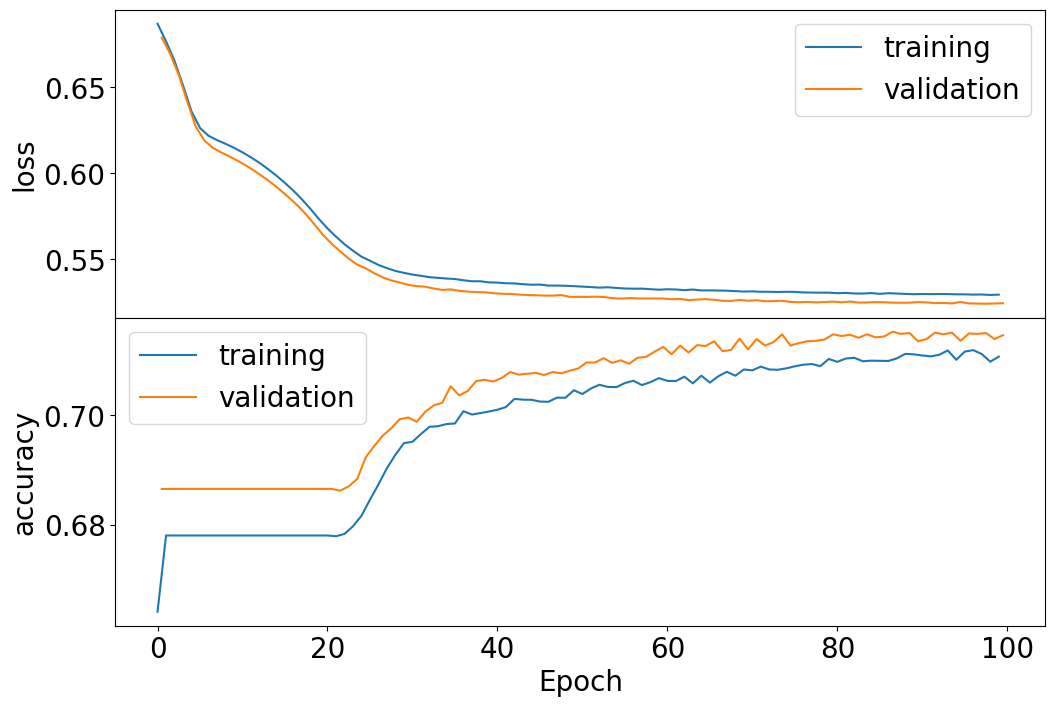

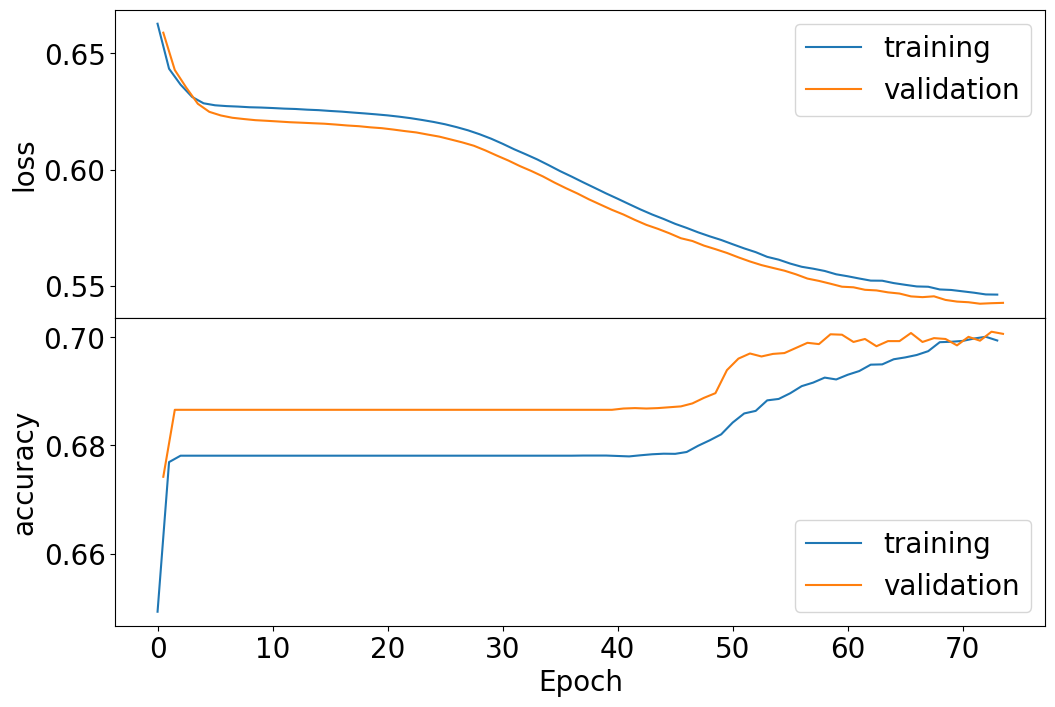

In [24]:
earlystop_callback = EarlyStopping(monitor='val_loss', patience=2)
pr = pruning_callbacks.UpdatePruningStep()
history = Deepset.fit(X_train2d, y_train2d, batch_size=1024, epochs=100, validation_split=0.25, shuffle=True)# callbacks=[earlystop_callback])
fig0, _ = plotTrainingHistory(history)
history = QDeepset.fit(X_train2d, y_train2d, batch_size=1024, epochs=100, validation_split=0.25, shuffle=True, callbacks=[earlystop_callback,pr])
fig1, _ = plotTrainingHistory(history)

In [25]:
QDeepset = strip_pruning(QDeepset)
QDeepset.compile(optimizer=adamQDS, loss=['binary_crossentropy'], metrics=['accuracy'])

In [28]:
trace = True
hls4ml.model.optimizer.get_optimizer("output_rounding_saturation_mode").configure(
        layers=[
#            "qrelu_n1",
#            "qrelu_g1",
#            "softmax_g2",
        ],
        rounding_mode="AP_RND",
        saturation_mode="AP_SAT",
    )
config = hls4ml.utils.config_from_keras_model(
        QDeepset, granularity="name",
        # default_precision="ap_fixed<16,6>"
        default_precision="ap_fixed<20,9>"
    )
config["Model"]["Strategy"] = "Latency"

    # Handle large span of numerical values in input
    # inputPrecision = "ap_fixed<12,4,AP_RND,AP_SAT>"
    # inputPrecision = "ap_fixed<16,7,AP_RND,AP_SAT>"
    # inputPrecision = "ap_fixed<18,8,AP_RND,AP_SAT>"
inputPrecision = "ap_fixed<20,9,AP_RND,AP_SAT>"

print ("Default generated config")
print (config)

for layer in QDeepset.layers:
        if layer.__class__.__name__ in ["BatchNormalization", "InputLayer"]:
            config["LayerName"][layer.name]["Precision"] = inputPrecision
            config["LayerName"][layer.name]["result"] = inputPrecision
            config["LayerName"][layer.name]["Trace"] = trace
        elif layer.__class__.__name__ in [
            "Permute",
            "Concatenate",
            "Flatten",
            "Reshape",
            # "GlobalAveragePooling1D",
            # "AveragePooling1D",
            "UpSampling1D",
            "Add",
        ]:
            print("Skipping trace for:", layer.name)
        else:
            config["LayerName"][layer.name]["Trace"] = trace

        for layerName in config["LayerName"]:
            config["LayerName"][layerName]["Trace"] = True


config["LayerName"]["output_class"]["Precision"]["result"] = inputPrecision
    
config["LayerName"]["avgpool"]["Precision"]["result"] = inputPrecision
config["LayerName"]["avgpool"]["Precision"] = inputPrecision

config["LayerName"]["qActivationForPool"]["Precision"]["result"] = inputPrecision
config["LayerName"]["qActivationForPool"]["Precision"] = inputPrecision

config["LayerName"]["output_class"]["Implementation"] = "latency"

print ("Changed  config")
print (config)

for layer in QDeepset.layers:
        if "qDense_phi" in layer.name:
            print ("Add custom pointwise implementation for layer", layer.name)
            config["LayerName"][layer.name]["ConvImplementation"] = "Pointwise"


layerNames = [layer.name for layer in QDeepset.layers]

for layer in QDeepset.layers:
        config["LayerName"][layer.name]["Strategy"] = "latency"

print("Converting the Keras Model !")


hls_model = hls4ml.converters.convert_from_keras_model(
        QDeepset,
        hls_config=config,
        # output_dir=output_dir,
        output_dir='Models',
        io_type="io_parallel",
#        part="xcvu9p-flgb2104-2l-e",
        # part="xcvu13p-flga2577-2-e", #real one
        part="xcu250-figd2104-2L-e",
        clock_period=2.5,
        # part="xcvu13p-flga2577-2-e",
        # clock_period=2.777777778,
)
hls_model.compile()

Interpreting Model
Topology:
Layer name: inputs, layer type: InputLayer, input shapes: [[None, 32, 12]], output shape: [None, 32, 12]
Layer name: batchnorm, layer type: BatchNormalization, input shapes: [[None, 32, 12]], output shape: [None, 32, 12]
Layer name: Dense_phi1, layer type: QDense, input shapes: [[None, 32, 12]], output shape: [None, 32, 16]
Layer name: Activation_phi1, layer type: Activation, input shapes: [[None, 32, 16]], output shape: [None, 32, 16]
Layer name: Dense_phi2, layer type: QDense, input shapes: [[None, 32, 16]], output shape: [None, 32, 16]
Layer name: Activation_phi2, layer type: Activation, input shapes: [[None, 32, 16]], output shape: [None, 32, 16]
Layer name: Dense_phi3, layer type: QDense, input shapes: [[None, 32, 16]], output shape: [None, 32, 16]
Layer name: Activation_phi3, layer type: Activation, input shapes: [[None, 32, 16]], output shape: [None, 32, 16]
Layer name: qActivationForPool, layer type: Activation, input shapes: [[None, 32, 16]], outpu

Exception: Failed to compile project "myproject"

In [33]:
y_test_pred_ds = Deepset.predict(X_test2d)
y_test_pred_qds = QDeepset.predict(X_test2d)
y_hls = hls_model.predict(X_test2d)
fpr, tpr, thr = roc_curve(y_test2d, y_test_pred_ds, drop_intermediate =False)
qfpr, qtpr, qthr = roc_curve(y_test2d, y_test_pred_qds, drop_intermediate =False)
hlsfpr, hlstpr, hlsthr = roc_curve(y_test2d, y_hls, pos_label=1, sample_weight=None, drop_intermediate=True)

1585/1585 [==============================] - 5s 3ms/step


Exception: Model not compiled

In [31]:
roc_auc = roc_auc_score(y_test2d, y_test_pred_ds)
qroc_auc = roc_auc_score(y_test2d, y_test_pred_qds)

In [32]:
hlsfpr *= totalMinBiasRate()
hlsroc_auc = roc_auc_score(y_test2d, y_hls)

f, ax  = plt.subplots(figsize=(8,6))
# plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14) 
ax.set_xlim(0,100)

ax.plot(fpr, tpr, color='green', lw=2, ls='dashed', label=f'Baseline (AUC = {roc_auc:.5f})')
ax.plot(qfpr, qtpr, color='red', lw=2, label=f'Quantized+Pruned (AUC = {qroc_auc:.5f})')
ax.plot(hlsfpr, hlstpr, color='purple', lw=3, ls='dotted', label=f'HLS Quantized+Pruned (AUC = {hlsroc_auc:.5f})')
ax.set_xlabel('L1 Rate (kHz)')
ax.set_ylabel('Signal efficiency')
ax.legend(prop={'size': 10},loc="lower right")
ax.grid(True)
plt.ylim(0,1)
plt.xlim(0,1)
plt

NameError: name 'y_hls' is not defined